In [1]:
### mounting the drive :

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.flush_and_unmount()

In [2]:
cd /content/drive/MyDrive/Amphan_book_seller/YOLO/

/content/drive/MyDrive/Amphan_book_seller/YOLO


In [3]:
!ls

data			     my_model_py_files	test2.csv   training_loss.txt
dataset.py		     old_txt_files	test3.csv   train.py
loss.py			     overfit2.pth.tar	test.csv    utils.py
Machine-Learning-Collection  overfit.pth.tar	train1.csv  validation_loss.txt
mean_avg_precision.txt	     __pycache__	train2.csv
model.py		     py_files		train3.csv
myfile.txt		     test1.csv		train.csv


**Training :::**



the training.py file contains the main function,so running this py file will start the training.But in this file we have few flags,which we have to edit inorder to get the control over the training.

1. **EPOCHS** : This flag is basically for controlling the number of epochs we want to train the model. 
2. **LEARNING_RATE** : This flag is basicallly to set the learning rate
3. **LOAD_MODEL** : As we need atleast 500 epochs to get a satisfying model but it will take a lot time.So i have broken this long process into several small epochs and saved the model after 100 or 200 epochs. And then when we started again we have to load the previous saved model. so this flag is for that control.If this flag is true then it will load the previously saved model in "LOAD_MODEL_FILE" .
4. **LOAD_BEST_MAP**: I have saved the model when it is achieving the best(highest) MAP(Mean avg. precision).So when i am starting the training from the last saved model, we have to load the last best map which our model has achieved.This flag is to control this work.If it is true then it will load the last best map from "myfile.txt".
5. **IMG_DIR/LABEL_DIR** : these flags contains the directory of images and labels respectively.

In [ ]:
!python train.py

hello
epoch:0
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Train mAP: 0.0
100% 23/23 [00:30<00:00,  1.31s/it, loss=213]
Mean training loss was 379.2343935759171
100% 5/5 [00:49<00:00,  9.99s/it, loss=250]
Mean validation loss was 223.66369018554687
epoch:1
Train mAP: 0.0
100% 23/23 [00:24<00:00,  1.07s/it, loss=117]
Mean training loss was 167.92296334971553
100% 5/5 [00:09<00:00,  1.93s/it, loss=140]
Mean validation loss was 160.20431823730468


**Testing :::**

In [ ]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import Counter
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.transforms.functional as FT
from tqdm import tqdm
from torch.utils.data import DataLoader
from py_files.model import Yolov1
from py_files.dataset import VOCDataset
from py_files.utils import (
    non_max_suppression,
    mean_average_precision,
    intersection_over_union,
    cellboxes_to_boxes,
    get_bboxes,
    save_checkpoint,
    load_checkpoint,
)
from py_files.loss import YoloLoss


In [ ]:
def plot_image(image, boxes):
    """Plots predicted bounding boxes on the image"""
    im = np.array(image)
    #print(im.shape)
    height, width, _ = im.shape
    #print(boxes)
    # Create figure and axes
    fig, ax = plt.subplots(1)
    # Display the image
    ax.imshow(im)

    # box[0] is x midpoint, box[2] is width
    # box[1] is y midpoint, box[3] is height

    # Create a Rectangle potch
    for box in boxes:
        box = box[2:]
        assert len(box) == 4, "Got more values than in x, y, h, w, in a box!"
        upper_left_x = box[0] - box[3] / 2
        upper_left_y = box[1] - box[2] / 2
        rect = patches.Rectangle(
            (upper_left_x * width, upper_left_y * height),
            box[3] * width,
            box[2] * height,
            linewidth=1,
            edgecolor="r",
            facecolor="none",
        )
        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()


In [ ]:
seed = 123
torch.manual_seed(seed)

# Hyperparameters etc. 
LEARNING_RATE = 2e-5
DEVICE = "cuda" if torch.cuda.is_available else "cpu"
BATCH_SIZE = 16 # 64 in original paper but I don't have that much vram, grad accum?
WEIGHT_DECAY = 0
EPOCHS = 10
NUM_WORKERS = 2
PIN_MEMORY = True
LOAD_MODEL = True
LOAD_MODEL_FILE = "overfit2.pth.tar"
IMG_DIR = "data/images2"
LABEL_DIR = "data/labels2"


In [ ]:
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, bboxes):
        for t in self.transforms:
            img, bboxes = t(img), bboxes

        return img, bboxes


transform = Compose([transforms.Resize((448, 448)), transforms.ToTensor(),])


In [ ]:
model = Yolov1(split_size=7, num_boxes=2, num_classes=20).to(DEVICE)
optimizer = optim.Adam(
        model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )
loss_fn = YoloLoss()

if LOAD_MODEL:
    load_checkpoint(torch.load(LOAD_MODEL_FILE), model, optimizer)

test_dataset = VOCDataset(
        "test2.csv", transform=transform, img_dir=IMG_DIR, label_dir=LABEL_DIR,
    )

test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        shuffle=True,
        drop_last=True,
    )




=> Loading checkpoint


In [ ]:
print(test_loader)

torch.Size([16, 3, 448, 448])


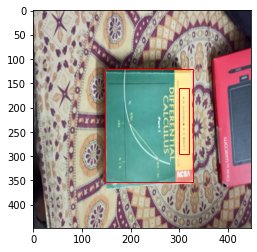

[[1.0, 0.9995421171188354, 0.6930328607559204, 0.508826494216919, 0.3027845025062561, 0.04369672015309334], [3.0, 0.9883320927619934, 0.5316097140312195, 0.5300384759902954, 0.519225537776947, 0.40684863924980164]]


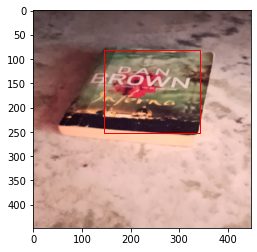

[[1.0, 1.0053590536117554, 0.5467554926872253, 0.3731648325920105, 0.3795914947986603, 0.4403316080570221]]


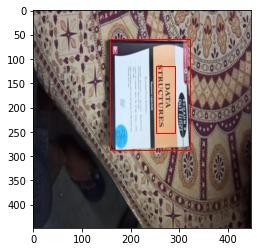

[[2.0, 1.0551713705062866, 0.6071153879165649, 0.40673092007637024, 0.30785316228866577, 0.08736947178840637], [1.0, 1.047799825668335, 0.5364646315574646, 0.3867819607257843, 0.5095910429954529, 0.37069588899612427]]


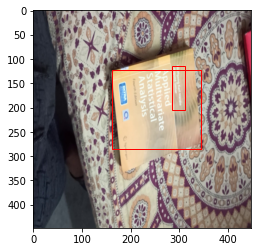

[[1.0, 1.0599606037139893, 0.5660481452941895, 0.455382764339447, 0.36363354325294495, 0.41271093487739563], [3.0, 1.0157910585403442, 0.6663210988044739, 0.35719603300094604, 0.20326143503189087, 0.0609571747481823]]


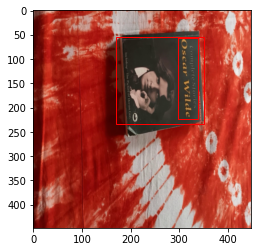

[[1.0, 1.13666570186615, 0.5819892287254333, 0.3230428397655487, 0.3998531699180603, 0.4039623439311981], [2.0, 0.6499415636062622, 0.709878146648407, 0.3131799101829529, 0.37029165029525757, 0.09330879896879196]]


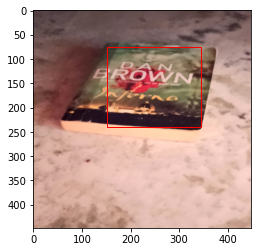

[[1.0, 1.0139131546020508, 0.5546376705169678, 0.35068267583847046, 0.36640772223472595, 0.43542638421058655]]


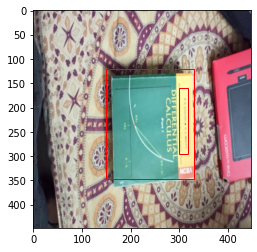

[[1.0, 1.056138515472412, 0.6903267502784729, 0.5075876116752625, 0.3036663234233856, 0.03730551153421402], [3.0, 1.0068211555480957, 0.5372142791748047, 0.5215453505516052, 0.5022891163825989, 0.4030400216579437]]


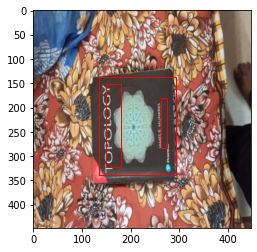

[[1.0, 0.9792801737785339, 0.47751951217651367, 0.5308181643486023, 0.448376327753067, 0.35294830799102783], [2.0, 0.9359452128410339, 0.36666643619537354, 0.5294312238693237, 0.3794536888599396, 0.06949349492788315], [3.0, 0.6905988454818726, 0.601659893989563, 0.5177862644195557, 0.23054954409599304, 0.026929087936878204]]
torch.Size([16, 3, 448, 448])


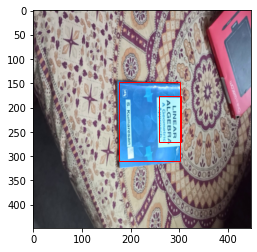

[[1.0, 1.0520795583724976, 0.5340631604194641, 0.5091857314109802, 0.36506810784339905, 0.2787691056728363], [2.0, 0.8928095102310181, 0.6285750269889832, 0.49897241592407227, 0.21468548476696014, 0.09815749526023865]]


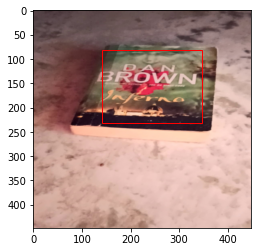

[[1.0, 1.1101243495941162, 0.5462239980697632, 0.3507002294063568, 0.3346821963787079, 0.4603475034236908]]


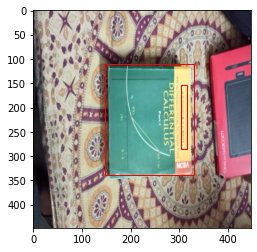

[[3.0, 1.055194616317749, 0.5349016189575195, 0.5004194974899292, 0.5083876252174377, 0.4104556143283844], [1.0, 1.0084930658340454, 0.6932722330093384, 0.4891699552536011, 0.2968236207962036, 0.025947658345103264]]


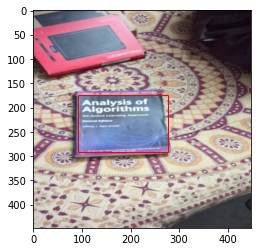

[[1.0, 0.8831250667572021, 0.4098820984363556, 0.5201794505119324, 0.2647641897201538, 0.4139181673526764]]


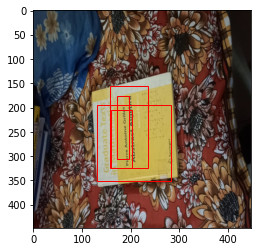

[[1.0, 0.8503243327140808, 0.4390374720096588, 0.5355698466300964, 0.3748333752155304, 0.17562173306941986], [3.0, 0.5115472674369812, 0.4060552418231964, 0.5903853178024292, 0.26736941933631897, 0.09675051271915436], [1.0, 0.5059251189231873, 0.4623839259147644, 0.6098769307136536, 0.3477337062358856, 0.34317436814308167], [2.0, 0.4090805649757385, 0.413077712059021, 0.536920428276062, 0.2898910641670227, 0.05528796464204788]]


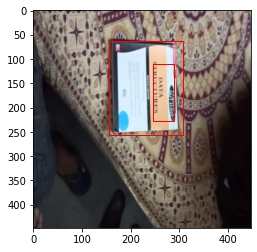

[[1.0, 1.028830885887146, 0.5183829069137573, 0.3561590015888214, 0.42908549308776855, 0.33930453658103943], [2.0, 0.8111947178840637, 0.5990231037139893, 0.3772667348384857, 0.26218709349632263, 0.09495487809181213]]


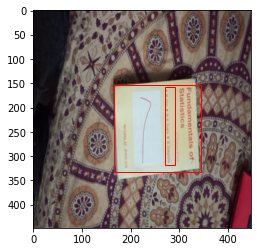

[[3.0, 1.0494232177734375, 0.6270983815193176, 0.5321890711784363, 0.359995037317276, 0.04426291212439537], [1.0, 1.038360357284546, 0.5712820887565613, 0.5421909093856812, 0.3956277072429657, 0.40120306611061096]]


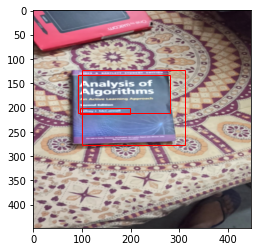

[[3.0, 0.9806290864944458, 0.330973356962204, 0.4631282687187195, 0.02701818384230137, 0.22938665747642517], [2.0, 0.8749445080757141, 0.4173940420150757, 0.3839881718158722, 0.17659138143062592, 0.42267510294914246], [1.0, 0.5778087973594666, 0.46098652482032776, 0.4445685148239136, 0.3433486819267273, 0.4726038873195648]]
torch.Size([16, 3, 448, 448])


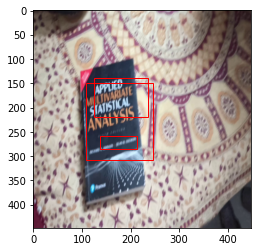

[[1.0, 0.9466726183891296, 0.39669936895370483, 0.5100929737091064, 0.3565114438533783, 0.31074267625808716], [2.0, 0.6217334270477295, 0.40356263518333435, 0.39942386746406555, 0.17781522870063782, 0.24755753576755524], [3.0, 0.606720507144928, 0.38989773392677307, 0.6056593656539917, 0.06127301603555679, 0.16856759786605835]]


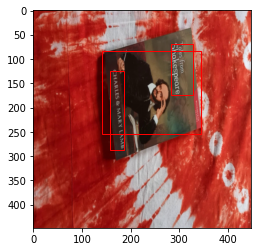

[[3.0, 0.9750890135765076, 0.3853422701358795, 0.45939400792121887, 0.3649333119392395, 0.06580714881420135], [1.0, 0.8252506256103516, 0.5428392887115479, 0.37758177518844604, 0.37927109003067017, 0.45571380853652954], [2.0, 0.7853087782859802, 0.6812288165092468, 0.27001628279685974, 0.23275592923164368, 0.10132047533988953]]


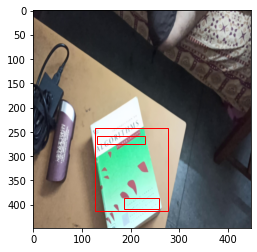

[[3.0, 1.0371792316436768, 0.49613073468208313, 0.8857851028442383, 0.05224552005529404, 0.1605273336172104], [2.0, 0.903832733631134, 0.4022032916545868, 0.5955322980880737, 0.03338990733027458, 0.2210327535867691], [1.0, 0.887454628944397, 0.44965270161628723, 0.7315770387649536, 0.38272589445114136, 0.3356132209300995]]


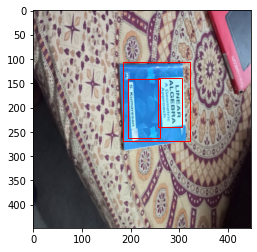

[[3.0, 0.8261037468910217, 0.5095033049583435, 0.4507669508457184, 0.2708047330379486, 0.1479911506175995], [2.0, 0.7961103916168213, 0.6290040016174316, 0.4228571355342865, 0.22878532111644745, 0.11276152729988098], [1.0, 0.6208251714706421, 0.5649260878562927, 0.4170326888561249, 0.36255255341529846, 0.3079230785369873]]


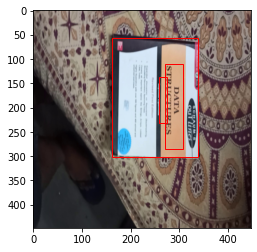

[[1.0, 1.0361648797988892, 0.5596741437911987, 0.39994391798973083, 0.5506702065467834, 0.39674222469329834], [3.0, 0.9131286144256592, 0.5963613986968994, 0.4113166034221649, 0.2134876549243927, 0.03985808417201042], [2.0, 0.805401086807251, 0.646364152431488, 0.4411429762840271, 0.3868042826652527, 0.08545432239770889]]


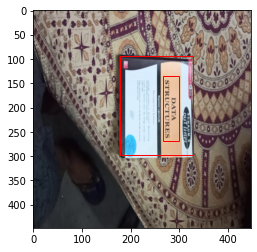

[[2.0, 1.0112364292144775, 0.6322619318962097, 0.4507024586200714, 0.2982310354709625, 0.07639787346124649], [1.0, 0.9600487351417542, 0.5663198232650757, 0.4369359612464905, 0.45386314392089844, 0.3391355574131012]]


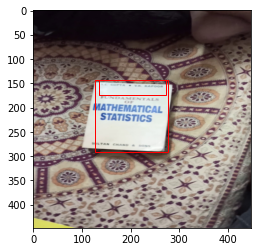

[[3.0, 0.9849412441253662, 0.45441725850105286, 0.3518359065055847, 0.06841345131397247, 0.31012555956840515], [1.0, 0.6626004576683044, 0.4504022002220154, 0.4855993986129761, 0.3306860625743866, 0.33671146631240845]]


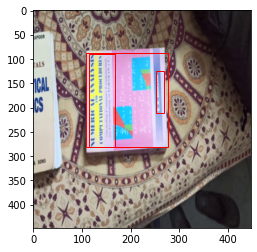

[[1.0, 1.0342260599136353, 0.43049949407577515, 0.41121917963027954, 0.43278560042381287, 0.3756679892539978], [2.0, 1.0241427421569824, 0.31617456674575806, 0.4130688011646271, 0.42874693870544434, 0.12209437787532806], [3.0, 0.9166773557662964, 0.5824360251426697, 0.3745023012161255, 0.19451527297496796, 0.037821248173713684]]
torch.Size([16, 3, 448, 448])


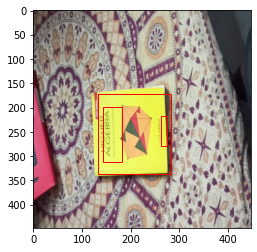

[[1.0, 1.1007864475250244, 0.464377224445343, 0.5670687556266785, 0.36604368686676025, 0.33253350853919983], [2.0, 1.001691222190857, 0.362751305103302, 0.5698093175888062, 0.25105026364326477, 0.08871825039386749], [3.0, 0.9665364027023315, 0.5994003415107727, 0.5532712340354919, 0.13808472454547882, 0.02959463559091091]]


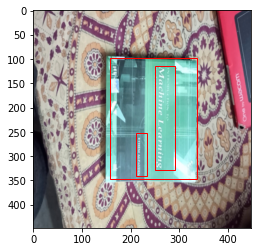

[[2.0, 1.0118459463119507, 0.6036384105682373, 0.49518710374832153, 0.4771032929420471, 0.09241936355829239], [3.0, 0.8787647485733032, 0.4964818060398102, 0.66170334815979, 0.196207195520401, 0.05351788178086281], [1.0, 0.8596667051315308, 0.5519077181816101, 0.4965037703514099, 0.5535626411437988, 0.39804089069366455]]


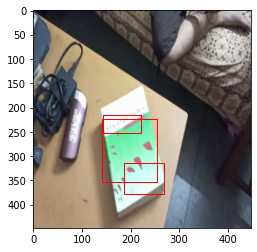

[[1.0, 0.6813488006591797, 0.44220083951950073, 0.6428117752075195, 0.28719502687454224, 0.25354886054992676], [2.0, 0.5597723126411438, 0.40699365735054016, 0.5209006667137146, 0.08601038157939911, 0.17095527052879333], [3.0, 0.5211459398269653, 0.5091955065727234, 0.7722702622413635, 0.1464434713125229, 0.18461483716964722]]


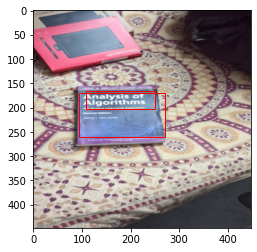

[[1.0, 1.021102786064148, 0.4068070352077484, 0.4803577959537506, 0.2000863403081894, 0.39295485615730286], [2.0, 0.7458863854408264, 0.4005095660686493, 0.4109426736831665, 0.08127181231975555, 0.32079049944877625]]


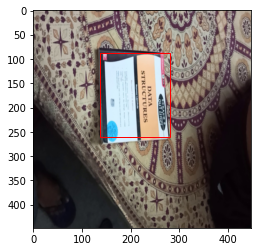

[[1.0, 0.868468165397644, 0.46744412183761597, 0.389670193195343, 0.3849271535873413, 0.3192708194255829]]


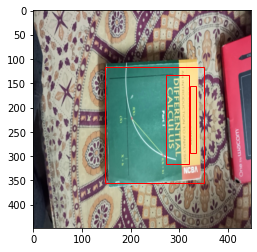

[[2.0, 1.063867449760437, 0.6628483533859253, 0.5005156397819519, 0.4096290171146393, 0.10872021317481995], [3.0, 0.9901905655860901, 0.5568734407424927, 0.5241162180900574, 0.5333742499351501, 0.4521644711494446], [1.0, 0.6654528975486755, 0.7326510548591614, 0.501511812210083, 0.3052319288253784, 0.02694382332265377]]


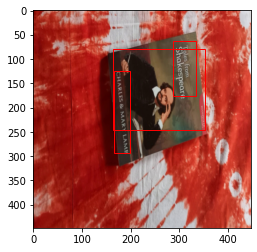

[[3.0, 0.9051649570465088, 0.4061587452888489, 0.4677429795265198, 0.37628474831581116, 0.07219001650810242], [2.0, 0.8376962542533875, 0.6955245137214661, 0.26718324422836304, 0.2504933476448059, 0.10757361352443695], [1.0, 0.6163679957389832, 0.5771187543869019, 0.36410456895828247, 0.37387651205062866, 0.42237937450408936]]


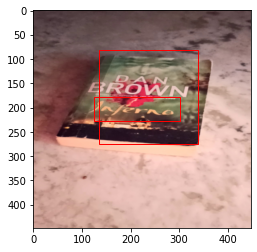

[[1.0, 1.0554070472717285, 0.5270400643348694, 0.39894136786460876, 0.4334731698036194, 0.45567786693573], [2.0, 0.946808397769928, 0.47582629323005676, 0.45291846990585327, 0.11268949508666992, 0.39243295788764954]]
torch.Size([16, 3, 448, 448])


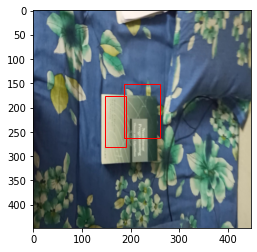

[[1.0, 0.6546970009803772, 0.501299262046814, 0.4628326892852783, 0.24695348739624023, 0.1652345359325409], [3.0, 0.4781331419944763, 0.37737998366355896, 0.508565366268158, 0.23525992035865784, 0.0938335731625557]]


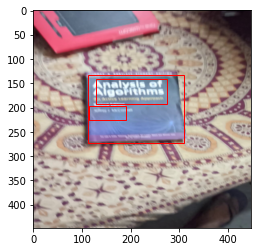

[[1.0, 1.0021040439605713, 0.47352713346481323, 0.45415323972702026, 0.3138144910335541, 0.4414522647857666], [3.0, 0.8794100880622864, 0.34235915541648865, 0.47087109088897705, 0.060210686177015305, 0.1711713969707489], [2.0, 0.6397529244422913, 0.4507945477962494, 0.3720274865627289, 0.11214335262775421, 0.3255457878112793]]


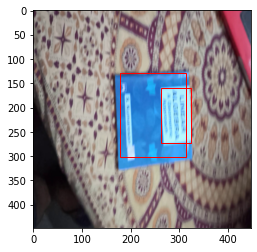

[[1.0, 0.8707433342933655, 0.5497386455535889, 0.47963157296180725, 0.3830774128437042, 0.3054884374141693], [2.0, 0.8577480316162109, 0.6565409898757935, 0.4812697470188141, 0.2538827061653137, 0.13994991779327393]]


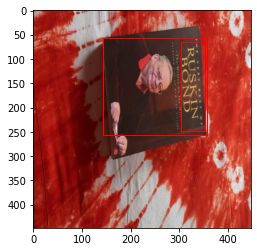

[[2.0, 1.0138245820999146, 0.7329644560813904, 0.34855881333351135, 0.41047602891921997, 0.11231501400470734], [1.0, 0.995187520980835, 0.5587653517723083, 0.3499507009983063, 0.4484039545059204, 0.47993478178977966]]


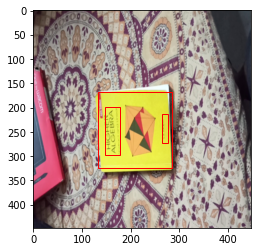

[[1.0, 1.04240083694458, 0.4667600095272064, 0.5477010011672974, 0.3505479693412781, 0.34153851866722107], [3.0, 0.9572064876556396, 0.6051070690155029, 0.5439869165420532, 0.13344918191432953, 0.030478693544864655], [2.0, 0.9284200072288513, 0.36403688788414, 0.5549705028533936, 0.22205986082553864, 0.07204928249120712]]


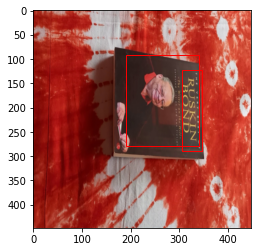

[[1.0, 0.6746821999549866, 0.5929501056671143, 0.4127346873283386, 0.416584849357605, 0.33511123061180115], [2.0, 0.6508378386497498, 0.7295013070106506, 0.459712415933609, 0.37270691990852356, 0.09292573481798172]]


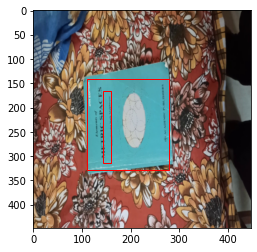

[[2.0, 0.9734973311424255, 0.3373156189918518, 0.5337814688682556, 0.3310495913028717, 0.038033582270145416], [1.0, 0.9715374112129211, 0.4346384108066559, 0.5229989290237427, 0.41843411326408386, 0.3805321455001831]]


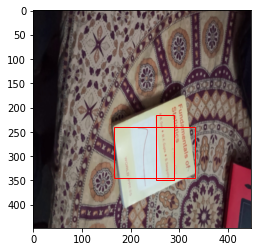

[[3.0, 0.8691775798797607, 0.6058518290519714, 0.6300853490829468, 0.3018466830253601, 0.08051973581314087], [1.0, 0.8595708608627319, 0.5565160512924194, 0.6529249548912048, 0.23582376539707184, 0.37436383962631226]]


In [ ]:
for x, y in test_loader:
      x = x.to(DEVICE)
      print(x.shape)
      for idx in range(8):
        #print(model(x))
        bboxes = cellboxes_to_boxes(model(x))
        bboxes = non_max_suppression(bboxes[idx], iou_threshold=0.5, threshold=0.4, box_format="midpoint")
        plot_image(x[idx].permute(1,2,0).to("cpu"), bboxes)
        print(bboxes)
    

In [ ]:
for x, y in test_loader:
      #x = x.to(DEVICE)
      print(type(y))
      print(y.shape)

<class 'torch.Tensor'>
torch.Size([16, 7, 7, 30])
<class 'torch.Tensor'>
torch.Size([16, 7, 7, 30])
<class 'torch.Tensor'>
torch.Size([16, 7, 7, 30])
<class 'torch.Tensor'>
torch.Size([16, 7, 7, 30])
<class 'torch.Tensor'>
torch.Size([16, 7, 7, 30])


**New inputs :::**

In [ ]:
from PIL import Image,ImageDraw
import imageio
import glob
import os

In [ ]:
class Compose1(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img):
        for t in self.transforms:
            img= t(img)

        return img


transform1 = Compose1([transforms.Resize((448, 448)), transforms.ToTensor()])


This undergiven function will draw the rectangles outside the object and save each and every frame of the video in a seperate file inside "**v_data_frames**" in a sepeate folder named after the video 

In [ ]:
#This function will draw the rectangles on the new video frames according to the parameters learned from out trained model

def plot_image1(image, boxes,path,img_nm,video):
    """Plots predicted bounding boxes on the image"""
    im = np.array(image)
        #print(im.shape)
    height, width, _ = im.shape

    # Create figure and axes
    fig, ax = plt.subplots(1)
    
    # Display the image
    #ax.imshow(im)

    # box[0] is x midpoint, box[2] is width
    # box[1] is y midpoint, box[3] is height

    # Create a Rectangle potch
    for box in boxes:
        clss=box[0]
        if clss==1:
            box = box[2:]
            assert len(box) == 4, "Got more values than in x, y, h, w, in a box!"
            upper_left_x = box[0] - box[3] / 2
            upper_left_y = box[1] - box[2] / 2
            lower_right_x = box[0] + box[3] / 2
            lower_right_y = box[1] + box[2] / 2
            shape=[(upper_left_x,upper_left_y),(lower_right_x,lower_right_y)]
            
            img2=cv2.imread(path)
            h,w,d=img2.shape

            img2=cv2.rectangle(img2,(int(shape[0][0]*w),int(shape[0][1]*h)),(int(shape[1][0]*w),int(shape[1][1]*h)),(0,255,0,255),7)
    cv2.imwrite("/content/drive/MyDrive/Amphan_book_seller/final_data/v_data_frames/"+video+"/"+img_nm+".jpg",img2)


This undergiven function will make a video with the output images of the previous function 

In [ ]:
def make_video(in_folder,out_folder):
  fp_in=in_folder
  fp_out=out_folder
  img_array = []
  for filename in glob.glob(fp_in):
    img = cv2.imread(filename)
    print(img.shape)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)
 
  
  out = cv2.VideoWriter(out_folder,cv2.VideoWriter_fourcc(*'DIVX'), 15, size)
 
  for i in range(len(img_array)):
      out.write(img_array[i])
  out.release()

In [ ]:
def pred(path,img_nm,video):
  img_nm=img_nm[:4]
  
  image = Image.open(path)
  imge=transform1(image)
  a=imge
  l=[]
  for i in range(16):
    l.append(a)
  a=torch.stack(l)

  img=a

  img = img.to(DEVICE)
  bboxes = cellboxes_to_boxes(model(img))
  bboxes = non_max_suppression(bboxes[0], iou_threshold=0.5, threshold=0.4, box_format="midpoint")

  plot_image1(img[0].permute(1,2,0).to("cpu"), bboxes,path,img_nm,video)
  #plot_image1(imge, bboxes)
  #print(bboxes)



In [ ]:
video='0036'

In [ ]:
#extracting the frames from the videos :

def extractFrames(pathIn, pathOut):
    os.mkdir(pathOut)
    cap = cv2.VideoCapture(pathIn)
    count = 0
    while (cap.isOpened()):
        # Capture frame-by-frame
        ret, frame = cap.read()
        if ret == True:
            print('Read %d frame: ' % count, ret)
            cv2.imwrite(os.path.join(pathOut, "{:04d}.jpg".format(count)), frame)  # save frame as JPEG file
            count += 1
        else:
            break
    # When everything done, release the capture
    cap.release()
    cv2.destroyAllWindows()

In [ ]:
path='/content/drive/MyDrive/Amphan_book_seller/final_data/p_data_frames/'+video


In [ ]:
# The first parameter is where the video is and the second parameter is where the frames is to be saved(which is "path",set in the previous cell)
extractFrames('/content/drive/MyDrive/Amphan_book_seller/final_data/'+video+'.mp4',path)

In [ ]:
#rotating the frames if needed :

flag=0
for file_name in os.listdir(path):
  if file_name.split(".")[-1].lower() in {"jpeg", "jpg", "png"}:
    img=cv2.imread(path+"/"+file_name)
    image = cv2.rotate(img, cv2.cv2.ROTATE_90_CLOCKWISE)
    #image = cv2.rotate(img, cv2.cv2.ROTATE_180)
    cv2.imwrite(path+"/"+file_name,image)


In [ ]:
#This portion will take each and every frame extracted from the video and then pass it through the prediction function
imgs=os.listdir(path)
for i in range(len(imgs)):
  #print(str(imgs[i]))
  pred(path+"/"+str(imgs[i]),str(imgs[i]),video)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
p_img_path="/content/drive/MyDrive/Amphan_book_seller/final_data/v_data_frames/"+video+"/*"
make_video(p_img_path,"/content/drive/MyDrive/Amphan_book_seller/final_data/v_data_frames/project001.avi")

(1280, 720, 3)
(1280, 720, 3)
(1280, 720, 3)
(1280, 720, 3)
(1280, 720, 3)
(1280, 720, 3)
(1280, 720, 3)
(1280, 720, 3)
(1280, 720, 3)
(1280, 720, 3)
(1280, 720, 3)
(1280, 720, 3)
(1280, 720, 3)
(1280, 720, 3)
(1280, 720, 3)
(1280, 720, 3)
(1280, 720, 3)
(1280, 720, 3)
(1280, 720, 3)
(1280, 720, 3)
(1280, 720, 3)
(1280, 720, 3)
(1280, 720, 3)
(1280, 720, 3)
(1280, 720, 3)
(1280, 720, 3)
(1280, 720, 3)
(1280, 720, 3)
(1280, 720, 3)
(1280, 720, 3)
(1280, 720, 3)
(1280, 720, 3)
(1280, 720, 3)
(1280, 720, 3)
(1280, 720, 3)
(1280, 720, 3)
(1280, 720, 3)
(1280, 720, 3)
(1280, 720, 3)
(1280, 720, 3)
(1280, 720, 3)
(1280, 720, 3)
(1280, 720, 3)
(1280, 720, 3)
(1280, 720, 3)
(1280, 720, 3)
(1280, 720, 3)
(1280, 720, 3)
(1280, 720, 3)
(1280, 720, 3)
(1280, 720, 3)
(1280, 720, 3)
(1280, 720, 3)
(1280, 720, 3)
(1280, 720, 3)
(1280, 720, 3)
(1280, 720, 3)
(1280, 720, 3)
(1280, 720, 3)
(1280, 720, 3)
(1280, 720, 3)
(1280, 720, 3)
(1280, 720, 3)
(1280, 720, 3)
(1280, 720, 3)
(1280, 720, 3)
(1280, 720

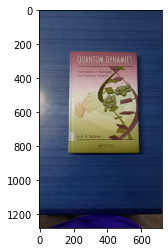

In [ ]:
### use of pytesseract:::::::::::::::
fr=os.listdir("/content/drive/MyDrive/Amphan_book_seller/final_data/v_data_frames/0036/")
img_f=cv2.imread("/content/drive/MyDrive/Amphan_book_seller/final_data/p_data_frames/0036/"+fr[55])
#print((len(fr)//2)-1)
h,w,l=img_f.shape
plt.imshow(img_f)

In [ ]:
def pred1(path):  
  image = Image.open(path)
  imge=transform1(image)
  a=imge
  l=[]
  for i in range(16):
    l.append(a)
  a=torch.stack(l)

  img=a

  img = img.to(DEVICE)
  bboxes = cellboxes_to_boxes(model(img))
  bboxes = non_max_suppression(bboxes[0], iou_threshold=0.5, threshold=0.4, box_format="midpoint")

  #plot_image1(img[0].permute(1,2,0).to("cpu"), bboxes,path,img_nm,video)
  #plot_image1(imge, bboxes)
  #print(bboxes)
  return bboxes

In [ ]:
boxes=pred1("/content/drive/MyDrive/Amphan_book_seller/final_data/p_data_frames/0036/"+fr[55])

print(boxes)

[[1.0, 0.8026108145713806, 0.5300585031509399, 0.4097779095172882, 0.4357517659664154, 0.5135622024536133], [2.0, 0.7203164100646973, 0.6302320957183838, 0.46383628249168396, 0.43793171644210815, 0.2585950195789337], [3.0, 0.4814433157444, 0.4334283769130707, 0.508854866027832, 0.3302691578865051, 0.19117587804794312]]


[(196, 245), (566, 803)]
(558, 370, 3)


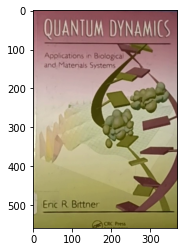

In [ ]:
for box in boxes:
  if box[0]==1:
    box = box[2:]
    assert len(box) == 4, "Got more values than in x, y, h, w, in a box!"
    upper_left_x = int((box[0] - box[3] / 2)*w)
    upper_left_y = int((box[1] - box[2] / 2)*h)
    lower_right_x = int((box[0] + box[3] / 2)*w)
    lower_right_y = int((box[1] + box[2] / 2)*h)
    shape=[(upper_left_x,upper_left_y),(lower_right_x,lower_right_y)]
    print(shape)
    img1=img_f[upper_left_y:lower_right_y,upper_left_x:lower_right_x]
    plt.imshow(img1)
    print(img1.shape)
            



In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 39 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 2s (3,045 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl

In [ ]:
import pytesseract
import shutil
import random
try:
 from PIL import Image
except ImportError:
 import Image

In [ ]:
#image_path_in_colab=''
extractedInformation = pytesseract.image_to_string(img1)
print(extractedInformation)

CUENTA Gs

Applications in Biological
and Matenals Systems

 
   

